In [7]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:

# Setting the current working directory
import os; os.chdir('drive/My Drive/')

In [10]:
!pwd

/content/drive/My Drive


In [12]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [13]:
# Imports
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

# Create features and labels
from tensorflow.keras.applications.mobilenet import preprocess_input
import cv2

# Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, Activation, BatchNormalization, SpatialDropout2D
from tensorflow.keras.applications.mobilenet import MobileNet
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import tensorflow as tf

# to define loss
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon

In [14]:
#Reference: https://stackoverflow.com/questions/55890813/how-to-fix-object-arrays-cannot-be-loaded-when-allow-pickle-false-for-imdb-loa
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle = True, **k)

data = np.load('images.npy')

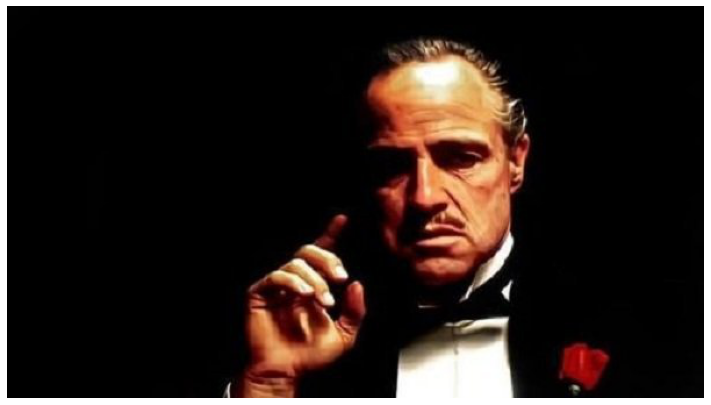

In [15]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(data[10][0])
plt.show()


**Create features and labels**
- Here feature is the image
- The label is the mask
- Images will be stored in 'X' array
- Masks will be stored in 'masks' array

In [16]:

ALPHA = 1
IMAGE_SIZE = 224
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

In [17]:
masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize = (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype = np.float32))
    for i in data[index][1]:
        x1 = int(i['points'][0]['x'] * IMAGE_WIDTH)
        x2 = int(i['points'][1]['x'] * IMAGE_WIDTH)
        y1 = int(i['points'][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i['points'][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

In [18]:

X.shape

(409, 224, 224, 3)

In [19]:
masks.shape

(409, 224, 224)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


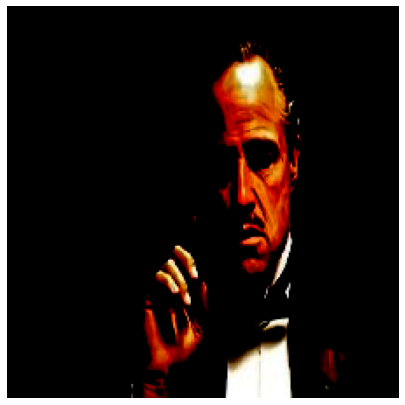

In [20]:
n = 10
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
_ = plt.imshow(X[n])

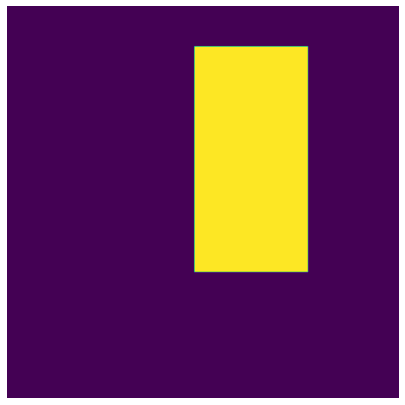

In [21]:
n = 10
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
_ = plt.imshow(masks[n])

**Create the model**
* Add MobileNet as model with below parameter values
-input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
-include_top: False
-alpha: 1.0
-weights: 'imagenet'
* Add UNET architecture layers

In [22]:

def conv_block_simple(prevlayer, filters, prefix, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), padding = 'same', kernel_initializer = 'he_normal', strides = strides, name = prefix + '_conv')(prevlayer)
    conv = BatchNormalization(name = prefix + 'BatchNormalization')(conv)
    conv = Activation('relu', name = prefix + 'ActivationLayer')(conv)
    return conv

def create_model(trainable = True):
    model = MobileNet(input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top = False, alpha = ALPHA, weights = 'imagenet')
    for layer in model.layers:
        layer.trainable = trainable
    
    block1 = model.get_layer('conv_pw_13_relu').output
    block2 = model.get_layer('conv_pw_11_relu').output
    block3 = model.get_layer('conv_pw_5_relu').output
    block4 = model.get_layer('conv_pw_3_relu').output
    block5 = model.get_layer('conv_pw_1_relu').output
    
    up1 = Concatenate()([UpSampling2D()(block1), block2])
    conv6 = conv_block_simple(up1, 256, 'Conv_6_1')
    conv6 = conv_block_simple(conv6, 256, 'Conv_6_2')

    up2 = Concatenate()([UpSampling2D()(conv6), block3])
    conv7 = conv_block_simple(up2, 256, 'Conv_7_1')
    conv7 = conv_block_simple(conv7, 256, 'Conv_7_2')

    up3 = Concatenate()([UpSampling2D()(conv7), block4])
    conv8 = conv_block_simple(up3, 192, 'Conv_8_1')
    conv8 = conv_block_simple(conv8, 128, 'Conv_8_2')

    up4 = Concatenate()([UpSampling2D()(conv8), block5])
    conv9 = conv_block_simple(up4, 96, 'Conv_9_1')
    conv9 = conv_block_simple(conv9, 64, 'Conv_9_2')

    up5 = Concatenate()([UpSampling2D()(conv9), model.input])
    conv10 = conv_block_simple(up5, 48, 'Conv_10_1')
    conv10 = conv_block_simple(conv10, 32, 'Conv_10_2')
    conv10 = SpatialDropout2D(0.2)(conv10)
    
    x = Conv2D(1, (1, 1), activation = 'sigmoid')(conv10)
    x = Reshape((IMAGE_SIZE, IMAGE_SIZE))(x)
    return Model(inputs = model.input, outputs = x)

In [23]:
model = create_model(True)
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
17227776/17225924 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112


**Define dice coefficient function**
- Create a function to calculate dice coefficient

In [24]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

**Define loss**

In [25]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

**Compile the model**

Complie the model using below parameters
- loss: use the loss function defined above
- optimizers: use Adam optimizer
- metrics: use dice_coefficient function defined above

In [26]:
adam = Adam(lr = 1e-4, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
model.compile(loss = loss, optimizer = adam, metrics = [dice_coefficient])

**Define checkpoint and earlystopping**

In [27]:
checkpoint = ModelCheckpoint('model_{loss:.2f}.h5', monitor = 'loss', verbose = 1, save_best_only = True, save_weights_only = True, mode = 'min', period = 1)
stop = EarlyStopping(monitor = 'loss', patience = 5, mode = 'min')
reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 5, min_lr = 1e-6, verbose = 1, mode = 'min')

**Fit the model**

Fit the model using below parameters
- epochs: you can decide
- batch_size: 1
- callbacks: checkpoint, reduce_lr, stop

In [28]:
X_train, X_valid, y_train, y_valid = train_test_split(X, masks, test_size = 0.15, random_state = 2019, shuffle = False)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((347, 224, 224, 3), (62, 224, 224, 3), (347, 224, 224), (62, 224, 224))

In [29]:
model.fit(X_train, y_train, epochs = 30, batch_size = 1, callbacks = [checkpoint, reduce_lr, stop], validation_data = (X_valid, y_valid))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 347 samples, validate on 62 samples
Epoch 1/30
345/347 [============================>.] - ETA: 0s - loss: 1.7937 - dice_coefficient: 0.3523
Epoch 00001: loss improved from inf to 1.79765, saving model to model_1.80.h5
347/347 [==============================] - 35s 101ms/sample - loss: 1.7976 - dice_coefficient: 0.3510 - val_loss: 1.4669 - val_dice_coefficient: 0.3727
Epoch 2/30
346/347 [============================>.] - ETA: 0s - loss: 1.2619 - dice_coefficient: 0.4467
Epoch 00002: loss improved from 1.79765 to 1.26400, saving model to model_1.26.h5
347/347 [==============================] - 16s 46ms/sample - loss: 1.2640 - dice_coefficient: 0.4459 - val_loss: 1.3004 - val_dice_coefficient: 0.4118
Epoch 3/30
346/347 [============================>.] - ETA: 0s - loss: 1.0715 - dice_coefficient: 0.5014
Epoch 00003: loss improved from 1.26400 to 1.07263, saving model to model_1.07.h5
347/

In [30]:
model.evaluate(X_valid, y_valid, verbose = 1)

62/62 [==============================] - 6s 103ms/sample - loss: 0.9247 - dice_coefficient: 0.5949


[0.9247086586490754, 0.59490573]

**Get the predicted mask for a sample image**

In [32]:
# Load previous model weight
WEIGHTS_FILE = "model_0.14.h5"
learned_model = create_model()
learned_model.load_weights(WEIGHTS_FILE)
y_pred = learned_model.predict(X_valid, verbose = 1)

62/62 [==============================] - 1s 22ms/sample


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


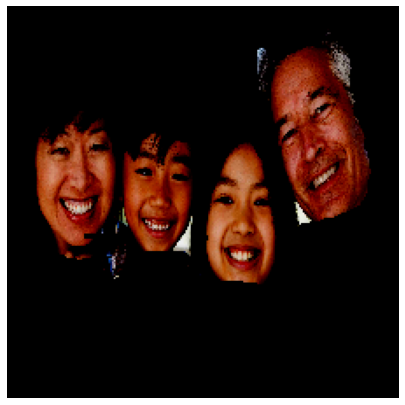

In [33]:
# For a sample image
n = 16
image = cv2.resize(X_valid[n], dsize = (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_CUBIC)
pred_mask = cv2.resize(1.0*(y_pred[n] > 0.1), (IMAGE_WIDTH, IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]
out_image = image2

fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(out_image)

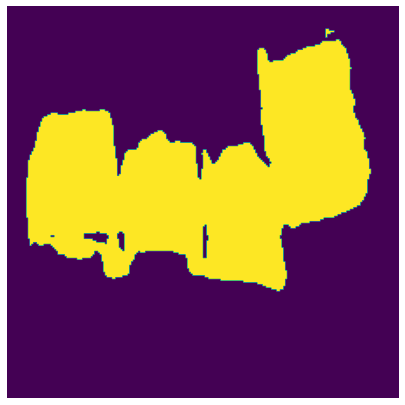

In [34]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(pred_mask, alpha = 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


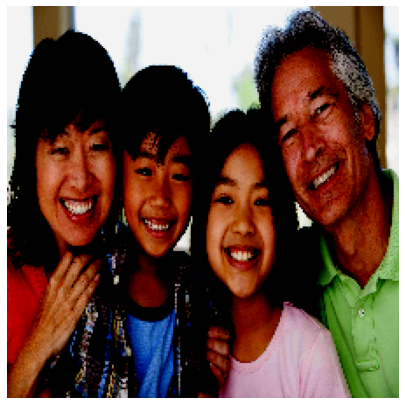

In [35]:

fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(X_valid[n])
plt.savefig('image.jpg', bbox_inches = 'tight', pad_inches = 0)

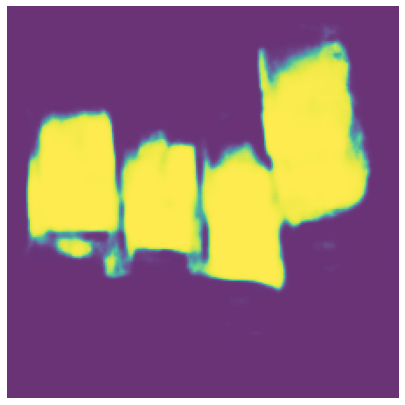

In [36]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(y_pred[n], alpha = 0.8)
plt.savefig('mask.jpg', bbox_inches = 'tight', pad_inches = 0)

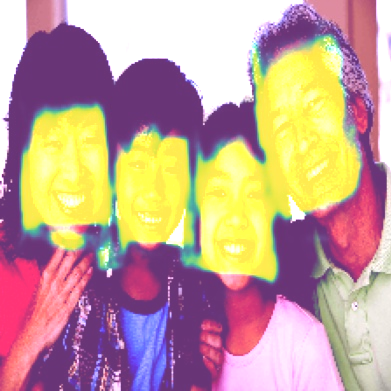

In [37]:
from google.colab.patches import cv2_imshow
img = cv2.imread('image.jpg', 1)
mask = cv2.imread('mask.jpg', 1)
img = cv2.add(img, mask)
cv2_imshow(img)